# Post Regression
In this notebook, we present a demo after training the neural network and obtaining the selection function. We first define some auxiliary functions to calculate the pseudo-power spectrum and mean target density.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.facecolor"] = "w"

import numpy as np
import healpy as hp
import fitsio as ft
from scipy.stats import binned_statistic



"""
        Some useful functions
    
"""
def make_hp(hpix, value, nside):
    """ A Function to create a HEALPix map
    """
    m_ = np.zeros(12*nside*nside)
    m_[:] = np.nan
    m_[hpix] = value
    
    return m_

def run_anafast(density, mask):
    """ A function to compute the angular pseudo-power spectrum
    """
    density_ = hp.ma(density)
    density_.mask = np.logical_not(mask)
    
    return hp.anafast(density_.filled())
    
def hist(ngal, frac, syst, bins, mask):
    """ A function to bin galaxy counts and 
    """
    ng,_,_ = binned_statistic(syst[mask], ngal[mask], statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst[mask], frac[mask], statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst[mask], syst[mask], statistic='mean', bins=bins)

    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)

    return (ns, mean)

## View observed vs prediction for any one model and save it as a selection.fits file:

columns in `input`: [('features', '>f8', (9,)), ('label', '>f8'), ('fracgood', '>f8'), ('hpix', '>i8')]
(381896,) (381896,) (381896, 9)


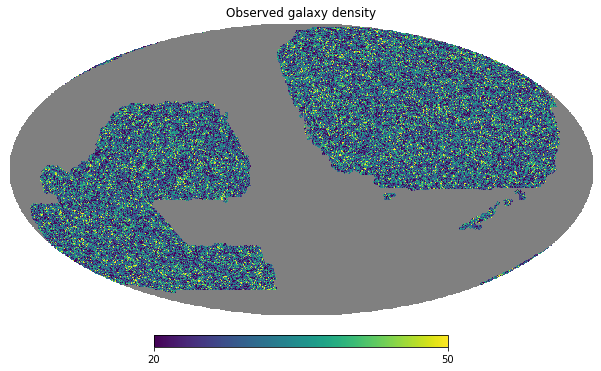

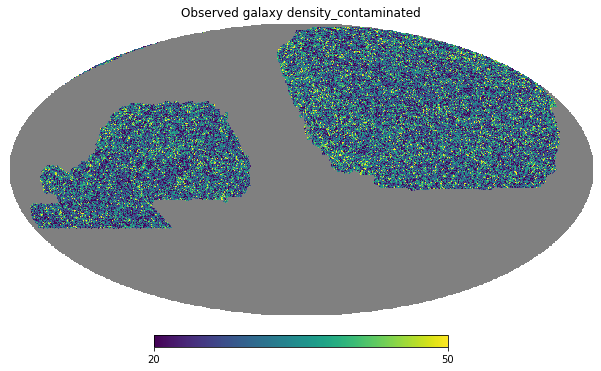

In [81]:
#
# importing general Python modules
#
import os
import sys 
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from pathlib import Path

# 
# importing SYSNET modules
# add the absolute path to 'sysnetdev'
sys.path.append('/home/jayashreeb/Documents/sysnet/sysnetdev')

from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

input1_path = '/mnt/data1/lognormal/0.57.0/nlrg_features_desi_256.fits'
input2_path = '/mnt/data1/lognormal/hpmaps/lrghp-zero-1-f1z1.fits'
input2_cpath = '/mnt/data1/lognormal/hpmaps/lrghp-czero-1-f1z1.fits'

input1 = ft.read(input1_path)  # read tab. data
print(f'columns in `input`: {input1.dtype}')
print(np.shape(input1["label"]),np.shape(input1["hpix"]),np.shape(input1["features"]))

input2 = hp.read_map(input2_path) # read hpmaps. data
input2_c = hp.read_map(input2_cpath) # read hpmaps. data

# repackage hpix and label to a HEALPix map for visualization purpose    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng_c = ng.copy()

mask = np.zeros(12*nside*nside)
mask[input1['hpix']] = True
input2[np.logical_not(mask)] = hp.UNSEEN
input2_c[np.logical_not(mask)] = hp.UNSEEN

ng[input1['hpix']] = input2[input1['hpix']]

# Mollweide projection
hp.mollview(ng, rot=-85, min=20, max=50,
            title='Observed galaxy density');

ng_c[input1['hpix']] = input2_c[input1['hpix']]
hp.mollview(ng_c, rot=-85, min=20, max=50,
            title='Observed galaxy density_contaminated');

In [102]:
name_model = 'dnnp'
path_model = '../output/nlrg_features_desi_256/zero/zero1_l1/model_0_2664486226/best.pth.tar'
kw_model = dict(nnstruct=(4, 20), num_features=5)

tm = TrainedModel(name_model, path_model, **kw_model)

In [103]:
axes = [1, 3, 5, 7, 8]  # all 18 imaging features used for training
hpix, npred = tm.forward(input1_path, axes=axes) 

ng_ = np.zeros(12*256*256)
ng_[:] = np.nan
ng_[hpix] = npred

/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying t

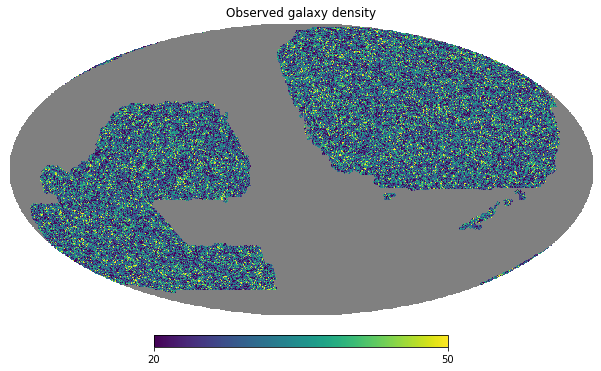

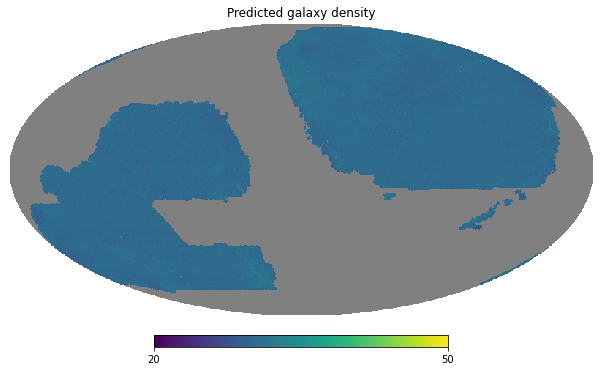

In [104]:
vmin, vmax = np.percentile(ng[hpix], [5, 95])
hp.mollview(ng, rot=-85, min=20, max=50,
            title='Observed galaxy density')

vmin, vmax = np.percentile(ng_[hpix], [5, 95])
hp.mollview(ng_, rot=-85, min=20, max=50,
            title='Predicted galaxy density')

In [105]:
hp.write_map('../output/nlrg_features_desi_256/zero/zero1/model_0_2664486226/selection.fits', ng_, 
             dtype='float64', fits_IDL=False, overwrite=True)

## Read Selection Function, Galaxy Density, Random Density, MASK

/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Available columns: [('features', '>f8', (9,)), ('label', '>f8'), ('fracgood', '>f8'), ('hpix', '>i8')]


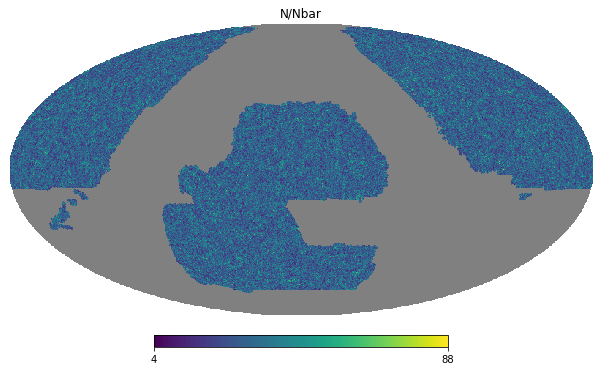

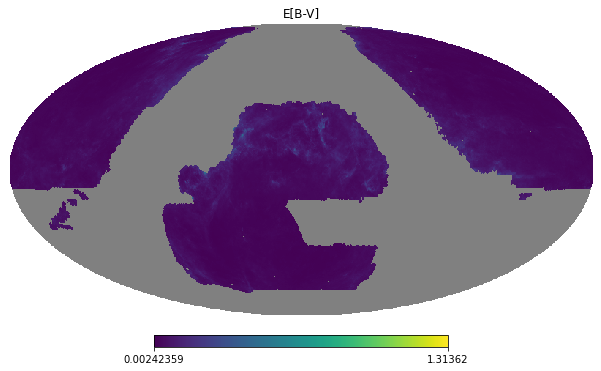

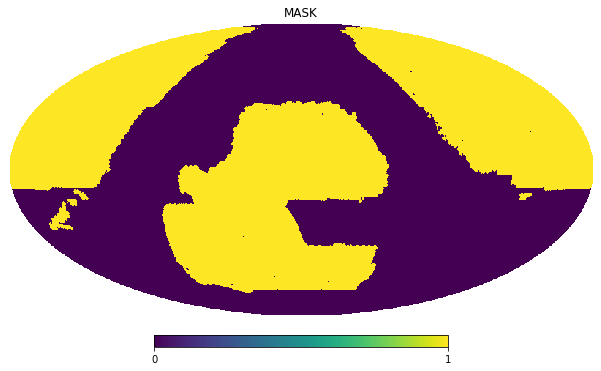

In [106]:
# read the selection function
npred = hp.read_map('../output/nlrg_features_desi_256/zero/zero1/model_0_2664486226/selection.fits')

# read data
nside = 256
data = ft.read(input1_path)
print(f'Available columns: {data.dtype}')

# nnbar: galaxy count (normalized or not-normalized), 
# frac: pixel completeness
# ebv: one imaging property
# mask: a binary mask in healpix
nnbar = make_hp(data['hpix'], input2[data['hpix']], nside)
frac  = make_hp(data['hpix'], data['fracgood'], nside)
ebv   = make_hp(data['hpix'], data['features'][:, 0], nside) # the 0th column is E[B-V]
mask = make_hp(data['hpix'], 1.0, nside)

mask = mask > 0.5  # to make it binary


# visualize some of these
hp.mollview(nnbar, title='N/Nbar')
hp.mollview(ebv, title='E[B-V]')
hp.mollview(mask, title='MASK')

## Mean Density vs E[B-V]

Text(0, 0.5, 'Mean Density')

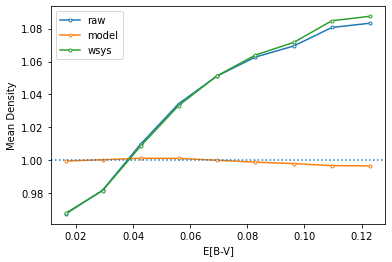

In [107]:
# determine the bins from the 2.5th and 97.5th quantiles of E[B-V]
bins = np.linspace(*np.percentile(ebv[mask], [2.5, 97.5]), 10) 

# compute mean density
nnbars = {}
nnbars['raw'] = hist(nnbar, frac, ebv, bins, mask)
nnbars['model'] = hist(npred*frac, frac, ebv, bins, mask)
nnbars['wsys'] = hist(nnbar/npred, frac, ebv, bins, mask)

# make a plot for mean density vs E[B-V]
for n_, nb_ in nnbars.items():
    plt.plot(*nb_, marker='.', mfc='w', label=n_)
    
plt.axhline(1.0, ls=':')
plt.legend()
plt.xlabel('E[B-V]')
plt.ylabel('Mean Density')

## Angular Power Spectrum

The mean density contrast $\delta$ can be defined in terms of the normalized mean density,
$$ \delta \equiv N/Nbar - 1$$

In [108]:
# get the density contrast from mean density
delta_raw = nnbar - 1.0
delta_wsys = nnbar/npred - 1.0

# compute pseudo-power spectrum
cl = {}
cl['raw'] = run_anafast(delta_raw, mask)
cl['wsys'] = run_anafast(delta_wsys, mask)

(1e-07, 0.1)

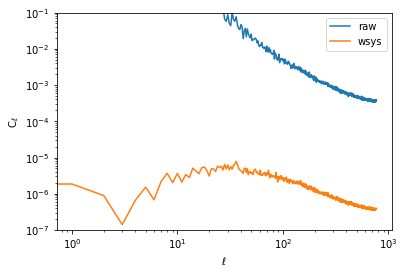

In [109]:
# plot pseudo-power vs ell
for n_, c_ in cl.items():
    plt.loglog(c_, label=n_)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.ylim(1.0e-7, 1.0e-1)

# Masking out high extinction regions

In [110]:
mask_new = mask & (ebv < 0.07)
mask_new.sum()/mask.sum()

0.8517030814672057

In [111]:
cl['raw-masked'] = run_anafast(delta_raw, mask_new)
cl['wsys-masked'] = run_anafast(delta_wsys, mask_new)

(1e-07, 6.0)

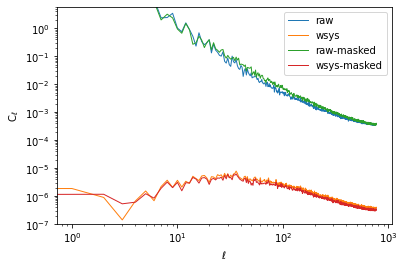

In [112]:
# plot pseudo-power vs ell
for n_, c_ in cl.items():
    plt.plot(c_, label=n_, lw=1)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.ylim(1.0e-7, 6.0)

## Neural network weights 

In [24]:
import torch
import os

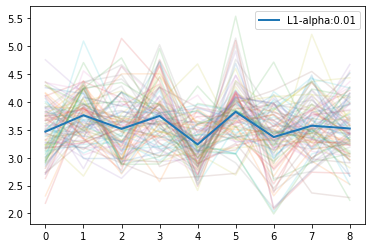

In [25]:
path="../output/nlrg_features_desi_256/zero/zero1/"

avg=0
n_models=0
matplotlib.rcParams["figure.facecolor"] = "w"

for f in os.listdir(path):
    if f[0:5]=="model":
        n_models+=1
        checkpoint = torch.load(path+f+"/best.pth.tar",map_location=torch.device('cpu'))
#         checkpoint.keys()
#         checkpoint["state_dict"],checkpoint['state_dict']['fc.0.weight']
        wts=checkpoint['state_dict']['fc.0.weight'].cpu().numpy()
#         plt.imshow(wts)
        avg=avg+abs(wts).sum(axis=0)
        plt.plot(abs(wts).sum(axis=0),alpha=0.15)
        plt.xticks(np.arange(9))
        
avg=avg/n_models

#matplotlib.rcParams["figure.facecolor"] = "w"
plt.plot(avg,linewidth=2,label="L1-alpha:0.01")
plt.xticks(np.arange(9))
plt.legend()
#plt.savefig("alpha1e-5.png")

In [31]:
np.where(abs(np.array(avg))>3.52)

(array([1, 3, 5, 7, 8]),)